## Home Price Prediction for Farglory Group with Python
 I started this mission by focusing on getting a good understanding of the dataset. So I conduct the price prediction based on the features of area_type, location, size, bath and closed price provided by the client survey report.
- Home buyers in Taiwan prefer to use the total "ping" instead of total_sqft instead, I have transformed it as sqft for easier to compare and read.(1 ping = 35.584 sqft)
- We build a machine learning model based on these information with skills of data cleansing with Python, feature engineering, dimensionality reduction, outliers detection with Pandas and Gridsearch CV with Scikit-learn.
- Once we completed the modeling, then we export it to a pickle file then write a flask server which consumes this pickle file to do prediction on the web page. 

### Loding libraries required and reading the data into Python

In [421]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter
df1 = pd.read_csv("tw_house_prices.csv")
df1.head()

,area_type,availability,location,size,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,"Zhongzheng Dist., Taipei City",2 BHK,1056,1.0,1.0,1015.82
1,Plot Area,Ready To Move,"Datong Dist., Taipei City",4 Bedroom,2600,2.0,3.0,3120.00
2,Built-up Area,Ready To Move,"Zhongshan Dist., Taipei City",3 BHK,1440,1.0,3.0,1612.00
3,Super built-up Area,Ready To Move,"Songshan Dist., Taipei City",3 BHK,1521,2.0,1.0,2470.00
4,Super built-up Area,Ready To Move,"Da’an Dist., Taipei Ci",2 BHK,1200,1.0,1.0,1326.00


### Check the features
- we are using supervised learning here so we need tag all label dataset before modeling

In [422]:
df1.columns

Index(['area_type', 'availability', 'location', 'size', 'total_sqft', 'bath',
       'balcony', 'price'],
      dtype='object')

In [423]:
df1['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [424]:
df1['area_type'].value_counts()

Super built-up  Area    8629
Built-up  Area          2371
Plot  Area              1983
Carpet  Area              87
Name: area_type, dtype: int64

### Data Cleansing
- handle N/A values and missing data
- drop the unnecessary features after internal discussions

In [425]:
df1.shape # shows the number of rows and columns of data

(13070, 8)

In [426]:
df1.groupby('area_type')['area_type'].agg('count')  # check the area type feature

area_type
Built-up  Area          2371
Carpet  Area              87
Plot  Area              1983
Super built-up  Area    8629
Name: area_type, dtype: int64

In [427]:
df2 = df1.drop(['area_type','balcony','availability'],axis='columns')
df2

,location,size,total_sqft,bath,price
0,"Zhongzheng Dist., Taipei City",2 BHK,1056,1.0,1015.82
1,"Datong Dist., Taipei City",4 Bedroom,2600,2.0,3120.00
2,"Zhongshan Dist., Taipei City",3 BHK,1440,1.0,1612.00
3,"Songshan Dist., Taipei City",3 BHK,1521,2.0,2470.00
4,"Da’an Dist., Taipei Ci",2 BHK,1200,1.0,1326.00
...,...,...,...,...,...
13065,"Jiadong Township, Pingtung County",5 Bedroom,3453,2.0,6006.00
13066,"Xinyuan Township, Pingtung County",4 BHK,3600,2.0,10400.00
13067,"Fangliao Township, Pingtung County",2 BHK,1141,1.0,1560.00
13068,"Fangshan Township, Pingtung County",4 BHK,4689,2.0,12688.00


In [428]:
# start data  cleaning
df2.isnull().sum()

location       0
size          14
total_sqft     0
bath          71
price          0
dtype: int64

71 rows where the value of bathroom is not available

In [429]:
df3 = df2.dropna()   # because we have 13070 rows so we can drop them
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [430]:
df3.shape

(12999, 5)

In [431]:
df3['size'].unique() #we can see there are 2 kinds of size, BHK and Bedroon

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

### Feature Engineering -1
**Add new feature(integer) for bhk (Bedrooms Hall Kitchen)** 

In [432]:
df3['bhk']=df3['size'].apply(lambda x: int(x.split(' ')[0]))

In [433]:
df3.head()

,location,size,total_sqft,bath,price,bhk
0,"Zhongzheng Dist., Taipei City",2 BHK,1056,1.0,1015.82,2
1,"Datong Dist., Taipei City",4 Bedroom,2600,2.0,3120.00,4
2,"Zhongshan Dist., Taipei City",3 BHK,1440,1.0,1612.00,3
3,"Songshan Dist., Taipei City",3 BHK,1521,2.0,2470.00,3
4,"Da’an Dist., Taipei Ci",2 BHK,1200,1.0,1326.00,2


In [434]:
df3['bhk'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

In [435]:
df3.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1454', '774', '4689'], dtype=object)

**Explore total_sqft features**

In [436]:
def is_float(x):              # to detect if a given value in total square foot column is a single number or not,
                              # we transform it as float
    try:
        float(x)
    except:
        return False
    return True

In [437]:
df3[~df3['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,"Pingxi Dist., New Taipei City",4 BHK,2100 - 2850,2.0,4836.00,4
122,"Wuri Dist., Taichung City",4 BHK,3067 - 8156,2.0,12402.00,4
137,"Dajia Dist., Taichung City",2 BHK,1042 - 1105,1.0,1404.13,2
165,"Nantou City, Nantou County",2 BHK,1145 - 1340,1.0,1130.74,2
188,"Taibao City, Chiayi County",2 BHK,1015 - 1540,1.0,1476.80,2
410,"Sanxia Dist., New Taipei City",1 BHK,34.46Sqt.Meter,1.0,481.00,1
549,"East Dist., Chiayi City",2 BHK,1195 - 1440,1.0,1658.02,2
648,"Mituo Dist., Kaohsiung City",9 Bedroom,4125ping,6.0,6890.00,9
661,"Jiaxian Dist., Kaohsiung City",2 BHK,1120 - 1145,1.0,1251.38,2
672,"Jinsha Township, Kinmen County",4 Bedroom,3090 - 5002,2.0,11570.00,4


- Above shows that total_sqft can be a range. So I take the average of min and max value in the range. and the 34.46Sq.Meter, 4125ping can convert to square ft using unit conversion. But I decide to drop them because they could be ignored.

In [438]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2  #we take the ranges avergae
    try:
        return float(x)
    except:
        return None

In [439]:
convert_sqft_to_num('2166') # test: give this function a string (transform to float)

2166.0

In [440]:
convert_sqft_to_num('2100 - 2850') # test: give this function a range (transform to float, returns as averge)

2475.0

In [441]:
df4 = df3.copy()
df4['total_sqft'] = df4['total_sqft'].apply(convert_sqft_to_num)
df4.head(3)

,location,size,total_sqft,bath,price,bhk
0,"Zhongzheng Dist., Taipei City",2 BHK,1056.0,1.0,1015.82,2
1,"Datong Dist., Taipei City",4 Bedroom,2600.0,2.0,3120.00,4
2,"Zhongshan Dist., Taipei City",3 BHK,1440.0,1.0,1612.00,3


In [442]:
df4.loc[30]

location      Pingxi Dist., New Taipei City
size                                  4 BHK
total_sqft                           2475.0
bath                                    2.0
price                                4836.0
bhk                                       4
Name: 30, dtype: object

- 2475 means average of range 2100-2850

In [443]:
(2100+2850)/2

2475.0

### Feature Engineering - 2
**Add new features price per square feet**

In [444]:
df4.head(3)

,location,size,total_sqft,bath,price,bhk
0,"Zhongzheng Dist., Taipei City",2 BHK,1056.0,1.0,1015.82,2
1,"Datong Dist., Taipei City",4 Bedroom,2600.0,2.0,3120.00,4
2,"Zhongshan Dist., Taipei City",3 BHK,1440.0,1.0,1612.00,3


In [446]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*10000/df5['total_sqft']  #change to NTD
df5.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,"Zhongzheng Dist., Taipei City",2 BHK,1056.0,1.0,1015.82,2,9619.507576
1,"Datong Dist., Taipei City",4 Bedroom,2600.0,2.0,3120.00,4,12000.000000
2,"Zhongshan Dist., Taipei City",3 BHK,1440.0,1.0,1612.00,3,11194.444444
3,"Songshan Dist., Taipei City",3 BHK,1521.0,2.0,2470.00,3,16239.316239
4,"Da’an Dist., Taipei Ci",2 BHK,1200.0,1.0,1326.00,2,11050.000000
5,"Wanhua Dist., Taipei City",2 BHK,1170.0,1.0,988.00,2,8444.444444
6,"Xinyi Dist., Taipei City",4 BHK,2732.0,2.0,5304.00,4,19414.348463
7,"Shilin Dist., Taipei City",4 BHK,3300.0,2.0,15600.00,4,47272.727273
8,"Beitou Dist., Taipei City",3 BHK,1310.0,2.0,1644.50,3,12553.435115
9,"Neihu Dist., Taipei City",6 Bedroom,1020.0,2.0,9620.00,6,94313.725490


### Removing outliers

In [447]:
len(df5.location.unique())  # explore the location column, dimenionality a little high

365

In [448]:
df5.location = df5.location.apply(lambda x: x.strip())
location_stats = df5.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats

location
Tamsui Dist., New Taipei City       71
Wenshan Dist., Taipei City          40
Bali Dist., New Taipei City         40
Baoshan Township, Hsinchu County    39
Ruifang Dist., New Taipei City      39
                                    ..
Da’an Dist., Taipei Ci               3
Nan’ao Township, Yilan Coun          2
Tai’an Township, Miaoli Coun         2
Su’ao Township, Yilan Coun           2
Ren’ai Dist., Keelung Ci             1
Name: location, Length: 365, dtype: int64

In [449]:
len(location_stats[location_stats<=10])

5

In [450]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

location
Da’an Dist., Taipei Ci          3
Nan’ao Township, Yilan Coun     2
Tai’an Township, Miaoli Coun    2
Su’ao Township, Yilan Coun      2
Ren’ai Dist., Keelung Ci        1
Name: location, dtype: int64

In [451]:
len(df5.location.unique())

365

In [452]:
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df5.location.unique())

361

In [453]:
df5.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,"Zhongzheng Dist., Taipei City",2 BHK,1056.0,1.0,1015.82,2,9619.507576
1,"Datong Dist., Taipei City",4 Bedroom,2600.0,2.0,3120.00,4,12000.000000
2,"Zhongshan Dist., Taipei City",3 BHK,1440.0,1.0,1612.00,3,11194.444444
3,"Songshan Dist., Taipei City",3 BHK,1521.0,2.0,2470.00,3,16239.316239
4,other,2 BHK,1200.0,1.0,1326.00,2,11050.000000
5,"Wanhua Dist., Taipei City",2 BHK,1170.0,1.0,988.00,2,8444.444444
6,"Xinyi Dist., Taipei City",4 BHK,2732.0,2.0,5304.00,4,19414.348463
7,"Shilin Dist., Taipei City",4 BHK,3300.0,2.0,15600.00,4,47272.727273
8,"Beitou Dist., Taipei City",3 BHK,1310.0,2.0,1644.50,3,12553.435115
9,"Neihu Dist., Taipei City",6 Bedroom,1020.0,2.0,9620.00,6,94313.725490


In [454]:
df5[df5.total_sqft/df5.bhk<250] #per knowledge, <250 is unreasonable design

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,"Neihu Dist., Taipei City",6 Bedroom,1020.0,2.0,9620.0,6,94313.725490
45,"Linkou Dist., New Taipei City",8 Bedroom,600.0,6.0,5200.0,8,86666.666667
58,"Sanxing Township, Yilan County",6 Bedroom,1407.0,2.0,3900.0,6,27718.550107
68,"Zhubei City, Hsinchu County",8 Bedroom,1350.0,3.0,2210.0,8,16370.370370
70,"Xinfeng Township, Hsinchu County",3 Bedroom,500.0,2.0,2600.0,3,52000.000000
...,...,...,...,...,...,...,...
12973,"Jiali Dist., Tainan City",9 Bedroom,1178.0,6.0,1950.0,9,16553.480475
13028,"Namaxia Dist., Kaohsiung City",7 Bedroom,1400.0,3.0,5668.0,7,40485.714286
13030,"Qieding Dist., Kaohsiung City",6 Bedroom,1200.0,2.0,3380.0,6,28166.666667
13053,"Neipu Township, Pingtung County",5 Bedroom,774.0,2.0,1820.0,5,23514.211886


In [455]:
df5.shape

(12999, 7)

In [456]:
df6 = df5[~(df5.total_sqft/df5.bhk<250)]
df6.shape

(12401, 7)

In [457]:
df6.price_per_sqft.describe() #detect the extreme values

count     12355.000000
mean      16530.957351
std       10983.658735
min         696.357515
25%       10971.470600
50%       13798.771121
75%       18138.413082
max      458823.529412
Name: price_per_sqft, dtype: float64

In [491]:
# Remove price per square outliers
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))] #keep the mean+-standard deviation
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df7 = remove_pps_outliers(df6)
df7.shape

(10317, 7)

In [492]:
df7

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,"Alian Dist., Kaohsiung City",2 BHK,883.0,1.0,1170.0,2,13250.283126
1,"Alian Dist., Kaohsiung City",1 BHK,750.0,1.0,1040.0,1,13866.666667
2,"Alian Dist., Kaohsiung City",3 BHK,1100.0,2.0,1378.0,3,12527.272727
3,"Alian Dist., Kaohsiung City",4 Bedroom,4000.0,2.0,8580.0,4,21450.000000
4,"Alian Dist., Kaohsiung City",2 BHK,985.0,1.0,1508.0,2,15309.644670
...,...,...,...,...,...,...,...
10312,other,3 BHK,1630.0,1.0,2548.0,3,15631.901840
10313,other,3 BHK,1260.0,1.0,2211.3,3,17550.000000
10314,other,2 BHK,1160.0,1.0,1144.0,2,9862.068966
10315,other,3 BHK,1150.0,1.0,2015.0,3,17521.739130


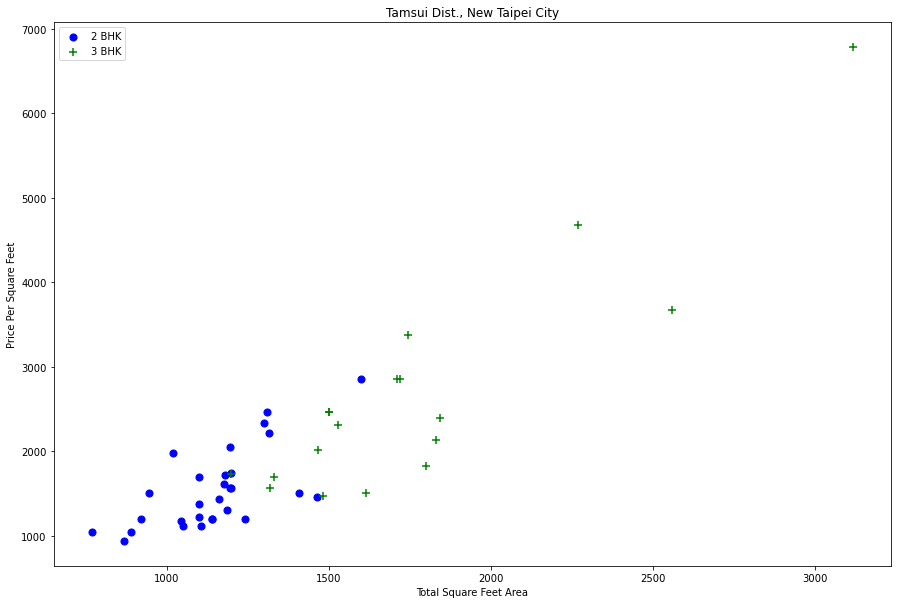

In [493]:
#plot two bedroom and three bedroom apartment for df7
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price, color='blue', label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price, marker='+', color = 'green', label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price Per Square Feet")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df7, "Tamsui Dist., New Taipei City")

We should remove properties where for same location, the price of (for example) 3 bedroom apartment(with same square ft area) less then the 2 bedrooms apartment.  
We can also remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment.

In [496]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):     #we create a dictionary
            bhk_stats[bhk] = {
                'mean':np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats =bhk_stats.get(bhk-1)
            if stats and stats['count'] > 5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values
            )
    return df.drop(exclude_indices,axis='index')

df8 = remove_bhk_outliers(df7)
df8.shape

(8486, 7)

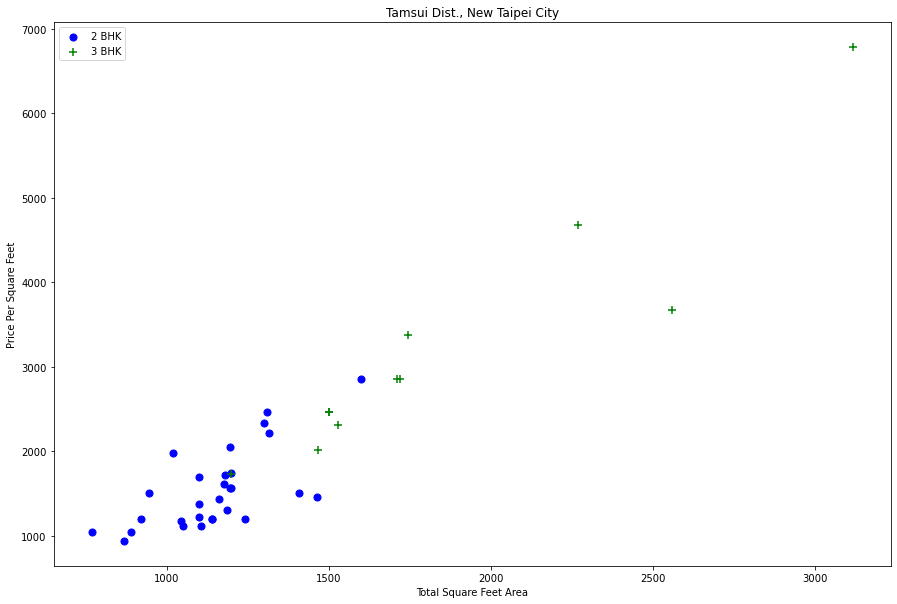

In [497]:
plot_scatter_chart(df8, "Tamsui Dist., New Taipei City")

Text(0, 0.5, 'Count')

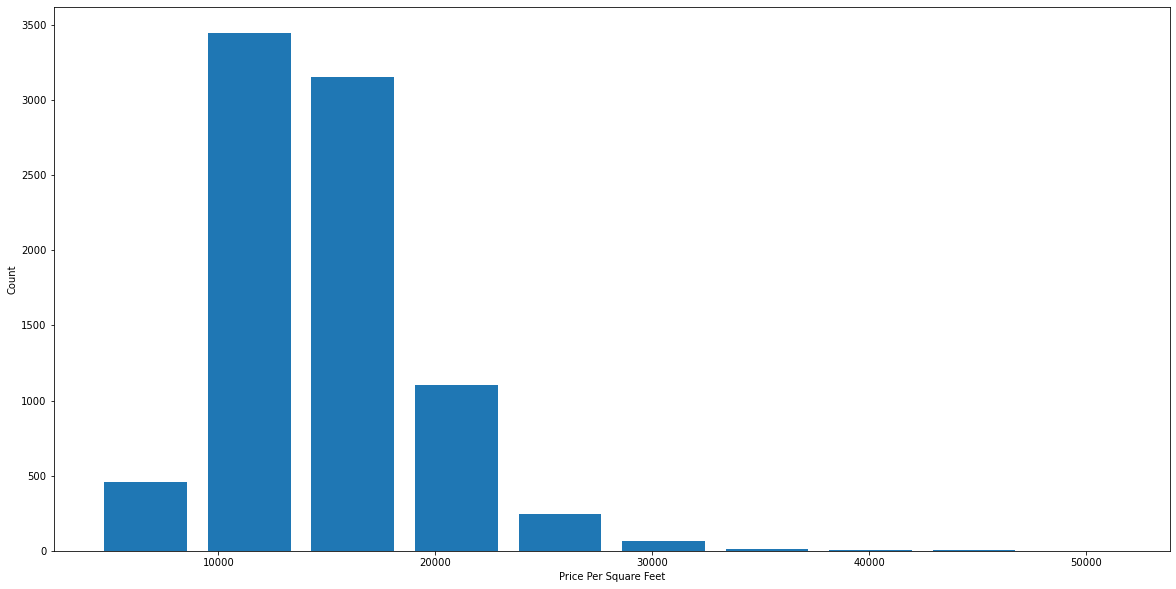

In [495]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df8.price_per_sqft, rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

x-axis is the Price Per Square Feet, y axis is number of data points in the category, a normal distribution like a Gaussian curve.

In [498]:
df8.bath.unique()   #check bathroom feature

array([ 1.,  2.,  3.,  6., 14., 12.])

In [500]:
df8[df8.bath>10]    #extreme values

,location,size,total_sqft,bath,price,bhk,price_per_sqft
2369,"Gangshan Dist., Kaohsiung City",16 BHK,10000.0,14.0,14300.0,16,14300.000000
6374,"Shanlin Dist., Kaohsiung City",13 BHK,5425.0,12.0,7150.0,13,13179.723502
7534,"Touwu Township, Miaoli County",10 BHK,4000.0,12.0,4160.0,10,10400.000000
8632,"Xinshe Dist., Taichung City",10 BHK,12000.0,12.0,13650.0,10,11375.000000


Text(0, 0.5, 'Count')

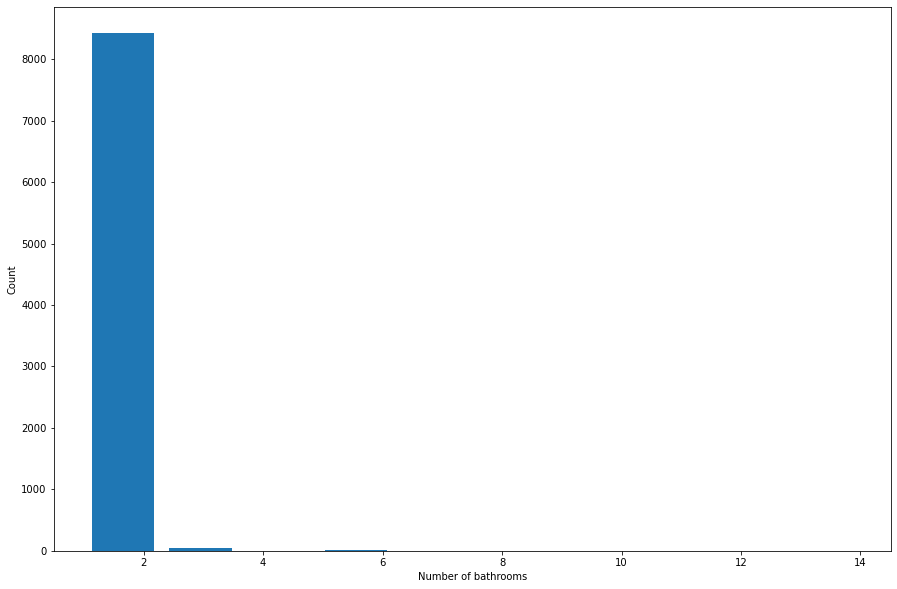

In [501]:
plt.hist(df8.bath, rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [502]:
df8[df8.bath>df8.bhk+2]  #we try to find out the bathroom outliers

,location,size,total_sqft,bath,price,bhk,price_per_sqft


In [503]:
df9 = df8[df8.bath<df8.bhk+2]
df9.shape

(8484, 7)

In [504]:
# Before starting to train the model, the size and price_per_sqft are unnecessary(we already have bhk feature)
df10 = df9.drop(['size','price_per_sqft'],axis='columns')   # price_per_sqft just for detecting the outliers, no other function)
df10.head()

,location,total_sqft,bath,price,bhk
0,"Alian Dist., Kaohsiung City",883.0,1.0,1170.0,2
1,"Alian Dist., Kaohsiung City",750.0,1.0,1040.0,1
2,"Alian Dist., Kaohsiung City",1100.0,2.0,1378.0,3
3,"Alian Dist., Kaohsiung City",4000.0,2.0,8580.0,4
4,"Alian Dist., Kaohsiung City",985.0,1.0,1508.0,2


### Creating Machine Learning Model

In [506]:
# Use one-hot encoding to transform categorial text information into numerical information
dummies = pd.get_dummies(df10.location)
dummies.head()

,"Alian Dist., Kaohsiung City","Alishan Township, Chiayi County","Anding Dist., Tainan City","Anle Dist., Keelung City","Annan Dist., Tainan City","Anping Dist., Tainan City","Bade Dist., Taoyuan City","Baihe Dist., Tainan City","Baisha Township, Penghu County","Bali Dist., New Taipei City",...,"Zhuolan Township, Miaoli County","Zhuoxi Township, Hualien County","Zhuqi Township, Chiayi County","Zhushan Township, Nantou County","Zhutang Township, Changhua County","Zhutian Township, Pingtung County","Ziguan Dist., Kaohsiung City","Zuoying Dist., Kaohsiung City","Zuozhen Dist., Tainan City",other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [508]:
df11 = pd.concat([df10,dummies],axis='columns')  #concatenate two dataframes: df11 and dummies
df11.head()

,location,total_sqft,bath,price,bhk,"Alian Dist., Kaohsiung City","Alishan Township, Chiayi County","Anding Dist., Tainan City","Anle Dist., Keelung City","Annan Dist., Tainan City",...,"Zhuolan Township, Miaoli County","Zhuoxi Township, Hualien County","Zhuqi Township, Chiayi County","Zhushan Township, Nantou County","Zhutang Township, Changhua County","Zhutian Township, Pingtung County","Ziguan Dist., Kaohsiung City","Zuoying Dist., Kaohsiung City","Zuozhen Dist., Tainan City",other
0,"Alian Dist., Kaohsiung City",883.0,1.0,1170.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Alian Dist., Kaohsiung City",750.0,1.0,1040.0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Alian Dist., Kaohsiung City",1100.0,2.0,1378.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Alian Dist., Kaohsiung City",4000.0,2.0,8580.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Alian Dist., Kaohsiung City",985.0,1.0,1508.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [509]:
df12 = df11.drop('location', axis='columns')  # in one-hot encoding we must less one column, we will choose to drop the last one
df12.head()

,total_sqft,bath,price,bhk,"Alian Dist., Kaohsiung City","Alishan Township, Chiayi County","Anding Dist., Tainan City","Anle Dist., Keelung City","Annan Dist., Tainan City","Anping Dist., Tainan City",...,"Zhuolan Township, Miaoli County","Zhuoxi Township, Hualien County","Zhuqi Township, Chiayi County","Zhushan Township, Nantou County","Zhutang Township, Changhua County","Zhutian Township, Pingtung County","Ziguan Dist., Kaohsiung City","Zuoying Dist., Kaohsiung City","Zuozhen Dist., Tainan City",other
0,883.0,1.0,1170.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,750.0,1.0,1040.0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1100.0,2.0,1378.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4000.0,2.0,8580.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,985.0,1.0,1508.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**So far, we completed the data processing pipeline (d1 ~d12)**

In [510]:
df12.shape

(8484, 365)

In [474]:
X =df12.drop('price', axis='columns') # "price" is the dependent variable, we drop it for model training
X.head()

,total_sqft,bath,bhk,"Alian Dist., Kaohsiung City","Alishan Township, Chiayi County","Anding Dist., Tainan City","Anle Dist., Keelung City","Annan Dist., Tainan City","Anping Dist., Tainan City","Bade Dist., Taoyuan City",...,"Zhuolan Township, Miaoli County","Zhuoxi Township, Hualien County","Zhuqi Township, Chiayi County","Zhushan Township, Nantou County","Zhutang Township, Changhua County","Zhutian Township, Pingtung County","Ziguan Dist., Kaohsiung City","Zuoying Dist., Kaohsiung City","Zuozhen Dist., Tainan City",other
0,883.0,1.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,750.0,1.0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1100.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4000.0,2.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,985.0,1.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**We keep all the independent variables**

In [511]:
X.shape

(8484, 364)

In [512]:
y = df12.price
y.head()

0    1170.0
1    1040.0
2    1378.0
3    8580.0
4    1508.0
Name: price, dtype: float64

In [477]:
len(y)

8484

#### We divide the dataset into training set and test set,  training set for data training and test dataset to evaluate the model performance

In [478]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10) #20% to be tests

In [479]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.8675008742282236

### Use K Fold cross validation to measure accuracy of LinearRegression Model

In [480]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0) #randomize the samples
cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.81325396, 0.85816222, 0.79383183, 0.82643067, 0.88333789])

We can see that in 5 iterations we get s score above 80%. This is pretty good but we want to test GridSearch to see if we can get even better score.

### Find the best model using GridSearchCV  
- We use GridSearch method to run different parameters on  different regressors and compare the scores.

In [515]:
from sklearn.model_selection import GridSearchCV   # Hyperparameter Tuning

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):       # Write a function to try my best model to compare the linear regression, lasso rgression and decision tree
    algos = {
        'linear_regression':{
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso':{
            'model': Lasso(),
            'params':{
                'alpha':[1,2],
                'selection':['random', 'cyclic']
            }
        },
        'decision_tree':{
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion':['mse','friedman_mse'],
                'splitter':['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():             # create a dictionary gs for 5 fold cross validation
        gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({                                 # append the scores into gs to call the best parameters
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
    return pd.DataFrame(scores, columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.835003,{'normalize': False}
1,lasso,0.836687,"{'alpha': 1, 'selection': 'cyclic'}"
2,decision_tree,0.817849,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


We can say that the Lasso gives the best score. But the result is very close to the LinearRegression. Hence we will use that. It will be easier to explain to the client.

In [516]:
X.columns

Index(['total_sqft', 'bath', 'bhk', 'Alian Dist., Kaohsiung City',
       'Alishan Township, Chiayi County', 'Anding Dist., Tainan City',
       'Anle Dist., Keelung City', 'Annan Dist., Tainan City',
       'Anping Dist., Tainan City', 'Bade Dist., Taoyuan City',
       ...
       'Zhuolan Township, Miaoli County', 'Zhuoxi Township, Hualien County',
       'Zhuqi Township, Chiayi County', 'Zhushan Township, Nantou County',
       'Zhutang Township, Changhua County',
       'Zhutian Township, Pingtung County', 'Ziguan Dist., Kaohsiung City',
       'Zuoying Dist., Kaohsiung City', 'Zuozhen Dist., Tainan City', 'other'],
      dtype='object', length=364)

### Test the model for some properties

In [517]:
np.where(X.columns=='Zuoying Dist., Kaohsiung City')[0][0]  #

361

In [484]:
def predict_price(location,sqft,bath,bhk):
    loc_index = np.where(X.columns==location)[0][0]
    
    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1
        
    return lr_clf.predict([x])[0]  #tell me the predicted price

In [485]:
predict_price('Zuoying Dist., Kaohsiung City',1000, 2, 2)  #1000 square feet, 2 bedroom and 2 bathroom apartment

1604.078609989383

In [518]:
predict_price('Zuoying Dist., Kaohsiung City',1000, 3, 3) #1000 square feet, 3 bedroom and 3 bathroom apartment

1760.6761126840247

In [487]:
predict_price('Songshan Dist., Taipei City',1000, 2, 2)

1571.671807391309

In [488]:
predict_price('Songshan Dist., Taipei City',1000, 3, 3) #--> go to A/B testing and ready for Flask API

1728.2693100859506

In [489]:
import pickle
with open('tw_home_prices_model.pickle', 'wb') as f:
    pickle.dump(lr_clf,f)

In [490]:
import json
columns = {
    'data_columns':[col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))